In [58]:
import os
import numpy as np
import pandas as pd
import random
import string
from itertools import groupby

import tensorflow as tf
from tensorflow.keras.utils import pad_sequences
from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam
import keras.backend as K
from keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [59]:
train_csv = pd.read_csv('./data/written_name_train_v2.csv')
val_csv = pd.read_csv('./data/written_name_validation_v2.csv')
train_img_dir = './data/train_v2/train'
val_img_dir = './data/validation_v2/validation'
print(train_csv.shape[0], val_csv.shape[0])
train_csv.head(5)
print(len(train_csv))

330961 41370
330961


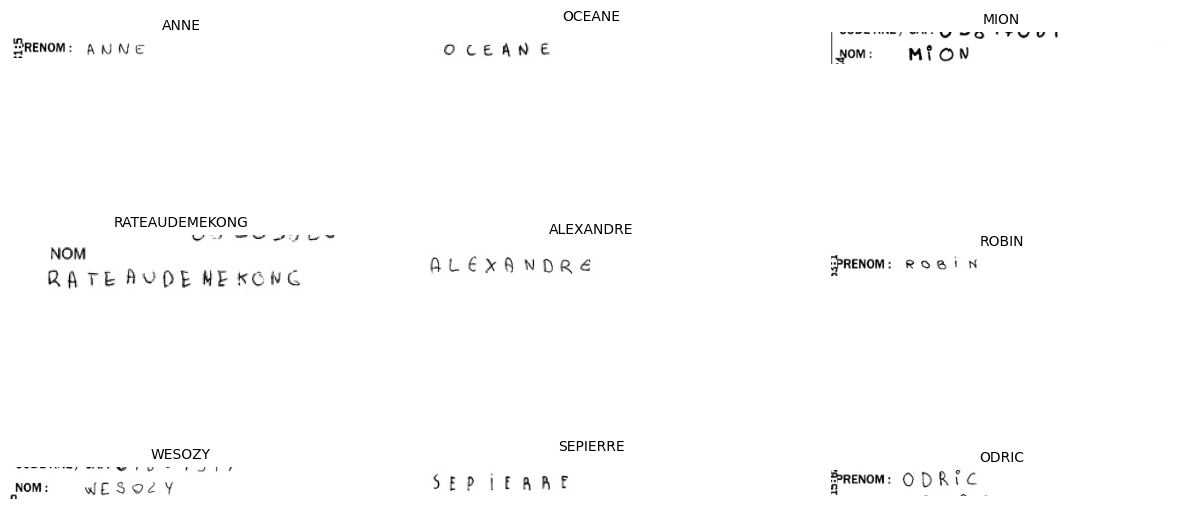

In [60]:
def visualization_data(data_csv, image_dir):
    # Set up the plot
    fig, axs = plt.subplots(3, 3, figsize=(15, 8))
    
    # Loop over the random images and plot the bounding boxes
    for i in range(9):
        row = i // 3
        col = i % 3
        
        idx = random.choice(data_csv.index)
        # Load the image
        image_path = os.path.join(image_dir, data_csv.loc[idx, 'FILENAME'])
        image = cv2.imread(image_path, 0)
        axs[row, col].imshow(image, cmap = 'gray')
        axs[row, col].set_title(data_csv.loc[idx, 'IDENTITY'], fontsize=10)
        axs[row, col].axis('off')
    plt.show()
    
visualization_data(train_csv, train_img_dir)

In [61]:
train_csv = train_csv[train_csv['IDENTITY'] != 'UNREADABLE']
val_csv = val_csv[val_csv['IDENTITY'] != 'UNREADABLE']
print(train_csv.shape[0], val_csv.shape[0])

330859 41358


In [62]:
train_csv = train_csv.sample(frac=0.001, random_state=42).reset_index(drop=True)
val_csv = val_csv.sample(frac=0.001, random_state=42).reset_index(drop=True)

print(train_csv)

             FILENAME       IDENTITY
0    TRAIN_233051.jpg          MANON
1     TRAIN_88894.jpg      EMELIANOV
2     TRAIN_99639.jpg  DOUAA-SABRINE
3    TRAIN_246055.jpg         NATHAN
4    TRAIN_264573.jpg        CANAMAS
..                ...            ...
326   TRAIN_91600.jpg       AMBROISE
327  TRAIN_163370.jpg       SAYASANE
328  TRAIN_282172.jpg       MOUHSSIM
329  TRAIN_330064.jpg          DYLAN
330   TRAIN_22066.jpg        LORYANE

[331 rows x 2 columns]


In [63]:
import os
import cv2
import numpy as np
import pandas as pd

def normalize_image(image_path):
    # Załaduj obraz w skali szarości
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Sprawdź, czy obraz został poprawnie załadowany
    if image is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    
    # Zmień rozmiar obrazu (jeśli konieczne)
    image = cv2.resize(image, (28, 28))
    
    # Znormalizuj wartości pikseli do zakresu [0, 1]
    normalized_image = image / 255.0
    
    return normalized_image

def normalize_images(image_dir, image_csv):
    normalized_images = []
    labels = []
    
    for idx, row in image_csv.iterrows():
        image_path = os.path.join(image_dir, row['FILENAME'])
        try:
            normalized_image = normalize_image(image_path)
            normalized_images.append(normalized_image)
            labels.append(row['IDENTITY'])
        except FileNotFoundError as e:
            print(e)
    
    return np.array(normalized_images), np.array(labels)

# Normalizacja danych treningowych
train_images, train_labels = normalize_images(train_img_dir, train_csv)

# Normalizacja danych walidacyjnych
val_images, val_labels = normalize_images(val_img_dir, val_csv)

# Sprawdź kształt znormalizowanych danych
print(f"Train images shape: {train_images.shape}")
print(f"Validation images shape: {val_images.shape}")

# Opcjonalnie: dodaj kanał dla zgodności z wejściem do sieci CNN
train_images = np.expand_dims(train_images, axis=-1)
val_images = np.expand_dims(val_images, axis=-1)

print(f"Train images shape after expanding dims: {train_images.shape}")
print(f"Validation images shape after expanding dims: {val_images.shape}")

Train images shape: (331, 28, 28)
Validation images shape: (41, 28, 28)
Train images shape after expanding dims: (331, 28, 28, 1)
Validation images shape after expanding dims: (41, 28, 28, 1)


In [64]:
alphabets = string.ascii_uppercase + "' -"
max_str_len = 24 # max length of input labels
num_of_characters = len(alphabets) + 1
num_of_timestamps = 64 # max length of predicted labels: 64
batch_size = 512

def encode_to_label(text):
    # Encoding each output word into digits
    dig_list = []
    for char in str(text):
        idx = alphabets.find(char)
        dig_list.append(idx if idx!=-1 else alphabets.find('-'))
    
    return pad_sequences([dig_list], maxlen=max_str_len, padding='post', value=-1)[0]

name = 'QUY DAU'
print(name, '\n', encode_to_label(name))

QUY DAU 
 [16 20 24 27  3  0 20 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


In [65]:
def decode_to_text(number_arr):
    text = ''
    for number in number_arr:
        if number == -1: # CTC blank
            break
        else:
            text += alphabets[number]

    return text

decode_to_text([16, 20, 24, 27, 3, 0, 20, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

'QUY DAU'

In [66]:
train_labels_encoded = [encode_to_label(label) for label in train_labels]
val_labels_encoded = [encode_to_label(label) for label in val_labels]
print()

In [67]:
# from tensorflow.keras.utils import to_categorical

# train_labels_encoded_categorical = to_categorical(train_labels)
# val_labels_encoded_categorical = to_categorical(val_labels)


In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, Reshape

# Tworzenie modelu
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), name='conv2d_1'),
    MaxPooling2D((2, 2), name='max_pooling2d_1'),
    Conv2D(64, (3, 3), activation='relu', name='conv2d_2'),
    MaxPooling2D((2, 2), name='max_pooling2d_2'),
    Flatten(name='flatten'),
    Dense(128, activation='relu', name='dense_1'),
    Dropout(0.5, name='dropout'),
    # Zamiast Reshape, użyj Flatten, aby uzyskać jednowymiarowy wektor
    Flatten(name='flatten_2'),
    # Zamiast warstwy LSTM, użyj warstwy Dense, która zwraca wektor o długości 24
    Dense(24, activation='softmax', name='dense_output')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Trenowanie modelu
history = model.fit(train_images, train_labels_encoded, epochs=10,
                    validation_data=(val_images, val_labels_encoded))


/Users/tomasz/Projects/Projekty PWr/projekt_naukowo_wzdrozeniowy/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 331
'y' sizes: 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24


In [ ]:
print(train_images.shape)
train_labels_encoded = np.array(train_labels_encoded)
print(train_labels_encoded.shape)

print(val_images.shape)
val_labels_encoded = np.array(val_labels_encoded)
print(val_labels_encoded.shape)

(331, 28, 28, 1)
(331, 24)
(41, 28, 28, 1)
(41, 24)
